<br>
<br>
# Predict Blood Donations
<br>
<br>

The objective of this notebook is to predict if a blood donor will donate within a given time window, given parameters such as months  since last donation (recency), number of donations made (frequency) , total volume of blood donated (cc) [monetary], months since first donation (time).

This is a warm-up problem in an ongoing competition at https://www.drivendata.org/competitions/2/warm-up-predict-blood-donations/page/7/

In [387]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,log_loss
from sklearn.model_selection import cross_val_score

from imblearn import over_sampling as os
from imblearn import under_sampling as us
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced
from collections import Counter
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA


from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

RANDOM_STATE = 2017

%matplotlib inline

In [214]:
from jupyterthemes import jtplot

jtplot.style('grade3', context='poster', fscale=1.5)
jtplot.style(ticks=True, grid=False)

In [405]:
df = pd.read_csv("transfusion.data.txt")

In [406]:
df.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [415]:
df.columns = ['months_since_last_donation', 'num_donations', 'vol_donations', 'months_since_first_donation', 'class']

In [416]:
df.head()

,months_since_last_donation,num_donations,vol_donations,months_since_first_donation,class
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


<br>
<br>
class 1 => the donor donated blood in March 2007 [let's call them donors]
<br>
class 0 => the donor did not donate blood in March 2007 [ let's call them non-donors ]
<br>
<br>

<br>
<br>
** Number of instances of each class **
<br>
<br>

In [417]:
df['class'].value_counts()

0    570
1    178
Name: class, dtype: int64

<br>
<br>
we see that there is a class imbalance problem here. We can fix this issue by oversampling the minority class (1) or undersampling the majority class.
<br>
<br>


<br>

---
## EDA
---
<br>
<br>

Let's explore the dataset and find out if we can get some interesting insights.

<br>

In [418]:
def ecdf(data):
    """
    returns empirical CDF of a data
    """
    n= len(data)
    x = np.array(sorted(data))
    y = np.arange(1,n+1)/(n*1.0)
    return x,y
    

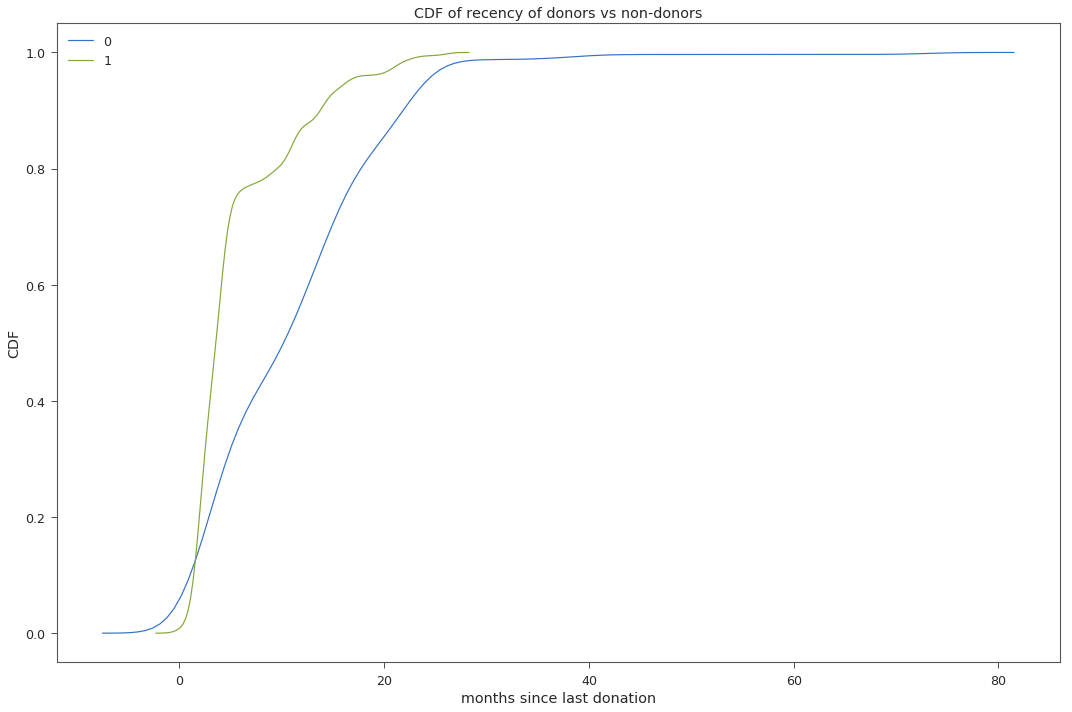

In [419]:
plt.figure(figsize=(15,10))
_ = sns.kdeplot(df[df['class']==0]['months_since_last_donation'],cumulative=True,label='0')
_ = sns.kdeplot(df[df['class']==1]['months_since_last_donation'],cumulative=True,label='1')
_ = plt.xlabel('months since last donation')
_ = plt.ylabel('CDF')
_ = plt.title('CDF of recency of donors vs non-donors')
plt.show();

<br>
<br>
People who are likely to donate blood again have donated blood more recently. The curve representing the CDF of donors (class 1) grows faster with less recency values than CDF of non-donors (class 0).
<br>
<br>

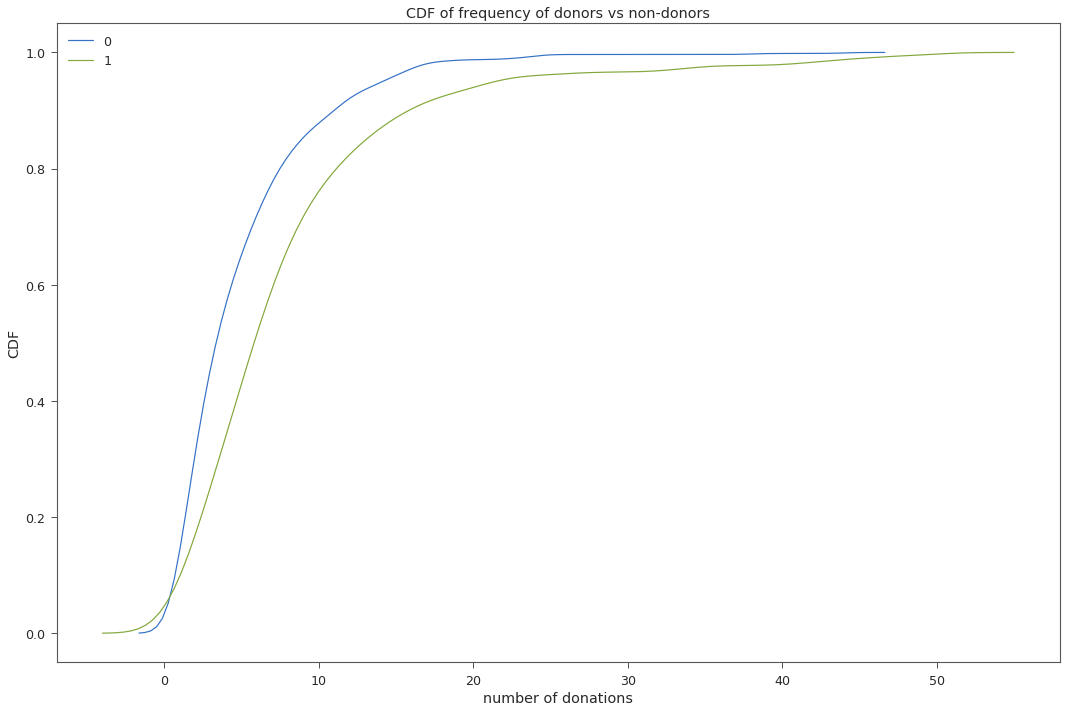

In [413]:
plt.figure(figsize=(15,10))
_ = sns.kdeplot(df[df['class']==0]['num_donations'],cumulative=True,label='0')
_ = sns.kdeplot(df[df['class']==1]['num_donations'],cumulative=True,label='1')
_ = plt.xlabel('number of donations')
_ = plt.ylabel('CDF')
_ = plt.title('CDF of frequency of donors vs non-donors')
plt.show()

<br>
<br>
From the above plot, we observe that donors donate more frequently than non-donors
<br>
<br>

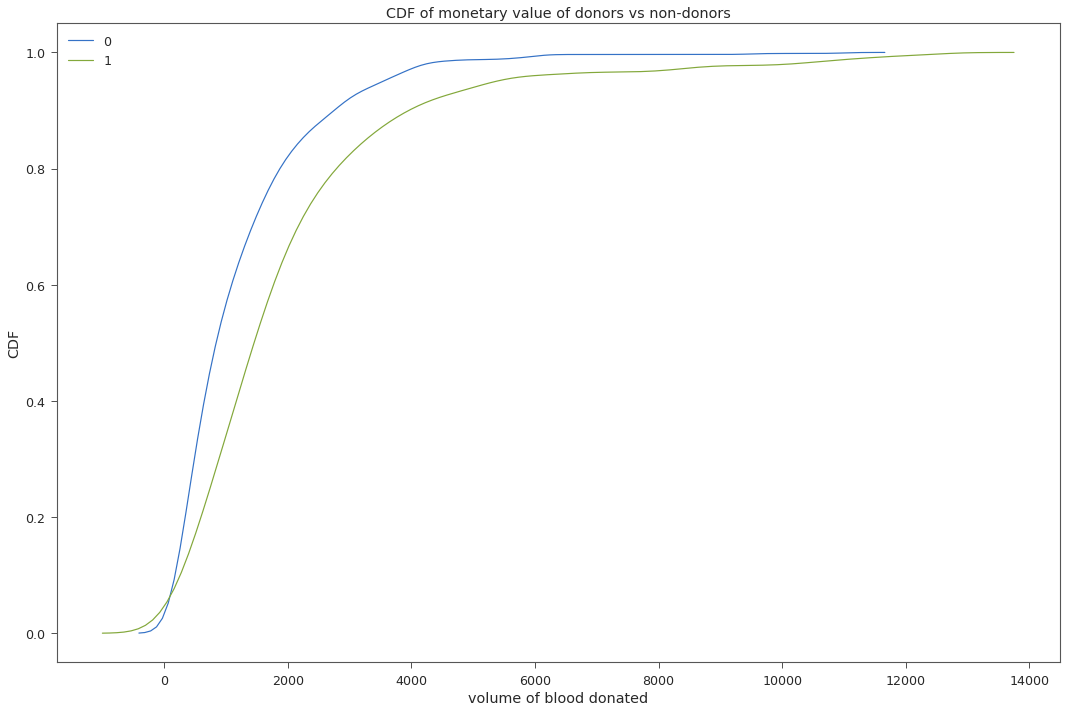

In [420]:
plt.figure(figsize=(15,10))
_ = sns.kdeplot(df[df['class']==0]['vol_donations'],cumulative=True,label='0')
_ = sns.kdeplot(df[df['class']==1]['vol_donations'],cumulative=True,label='1')
_ = plt.xlabel('volume of blood donated')
_ = plt.ylabel('CDF')
_ = plt.title('CDF of monetary value of donors vs non-donors')
plt.show()

<br>
<br>
The above CDF looks similar to the previous one. Frequency and monetary values are highly correlated. Here again, donars donate more volumne of blood than non-donors
<br>
<br>

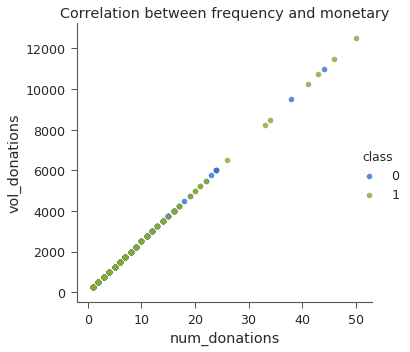

In [421]:
plt.figure(figsize=(15,10));
_ = sns.lmplot(x='num_donations',
               y='vol_donations',
               hue='class',
               fit_reg=False,
               data=df);
_ = plt.title("Correlation between frequency and monetary");
plt.show();

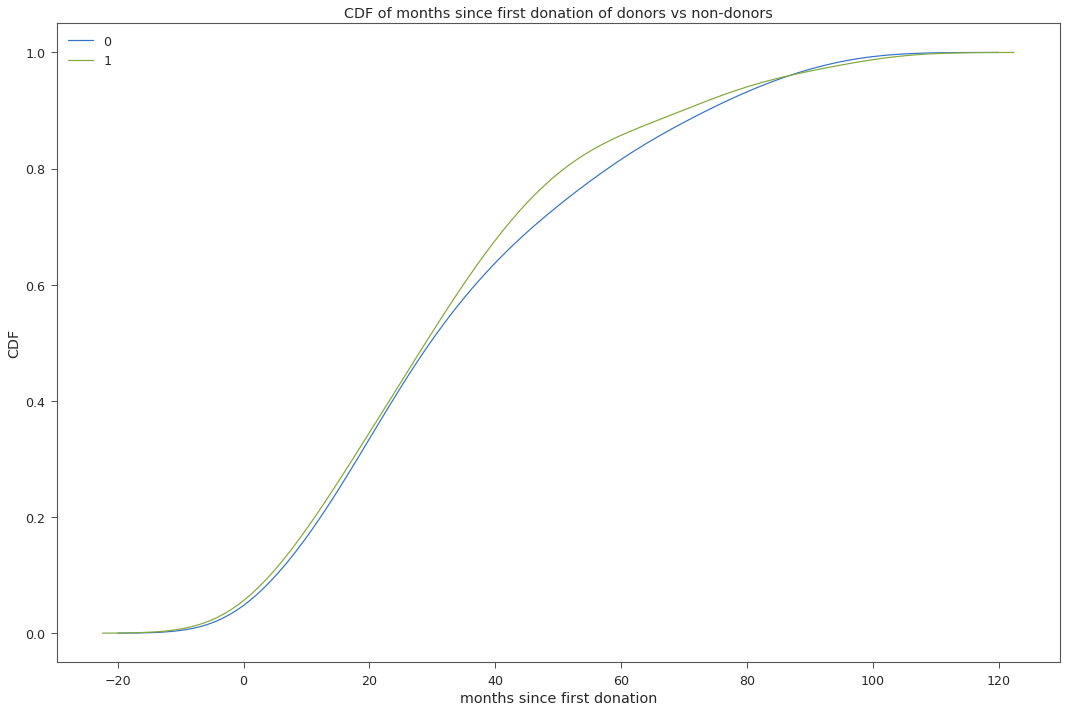

In [423]:
plt.figure(figsize=(15,10))
_ = sns.kdeplot(df[df['class']==0]['months_since_first_donation'],cumulative=True,label='0')
_ = sns.kdeplot(df[df['class']==1]['months_since_first_donation'],cumulative=True,label='1')
_ = plt.xlabel('months since first donation')
_ = plt.ylabel('CDF')
_ = plt.title('CDF of months since first donation of donors vs non-donors')
plt.show()

<br>
<br>
CDF of months since first donations is not so differentiable between the two classes.
<br>
<br>

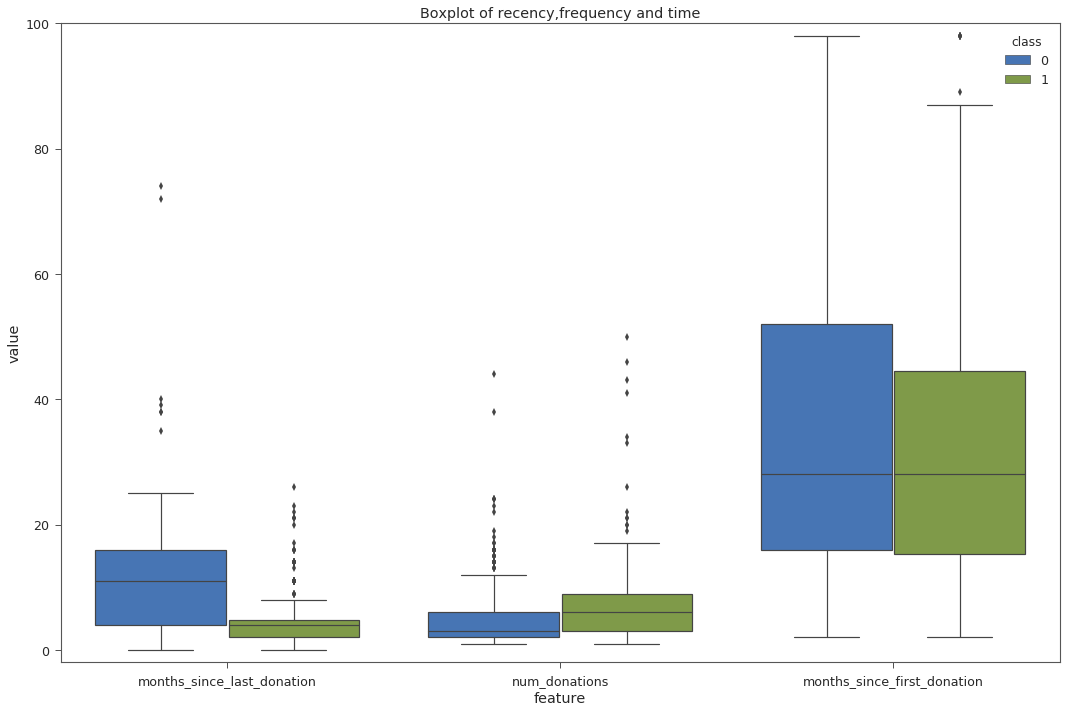

In [425]:
df_long = pd.melt(df,id_vars='class',var_name='feature')
plt.figure(figsize=(15,10))
_ = sns.boxplot(x='feature',y='value',hue='class',data=df_long[df_long.feature!='vol_donations'])
plt.margins(0.02)
_ = plt.title('Boxplot of recency,frequency and time')
plt.show()

<br>
<br>
we see that there are few outliers in recency and frequency for each of the classes. Should we remove them? What's the story behind these outliers?
<br>
<br>


---

## Prepare Data 

---

In [227]:
from sklearn.model_selection import train_test_split

<br>
<br>
Let's split our dataset into training and testing. We'll drop 'monetary' feature from our training data since it has high correlation to 'frequency'. It is a good practise to standardise our data.
<br>
<br>

In [426]:
x_train, x_test, y_train,y_test = train_test_split(df.drop(['class','vol_donations'],axis=1), df['class'], test_size = 0.1, random_state=2017)

In [427]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [428]:
x_train_scaled.mean(),x_train_scaled.std()

(-8.7982012847956928e-19, 1.0)

In [429]:
x_test_scaled.mean(),x_test_scaled.std()

(0.058943449584060933, 1.155008299202017)

---

## Resampling and Visualizations 

---

In [430]:
# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components=2,random_state=RANDOM_STATE)
# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(x_train_scaled)

pca_original_df = pd.DataFrame(X_vis,y_train).reset_index()
pca_original_df.columns = ['class','x','y']

# Apply SMOTE + Tomek links
sm = SMOTETomek()
X_resampled, y_resampled = sm.fit_sample(x_train_scaled, y_train)
X_res_vis = pca.transform(X_resampled)

pca_resampled_df = pd.DataFrame(X_res_vis,y_resampled).reset_index()
pca_resampled_df.columns = ['class','x','y']




<br>
<br>
**Visualizing original data in 2D**
<br>
<br>

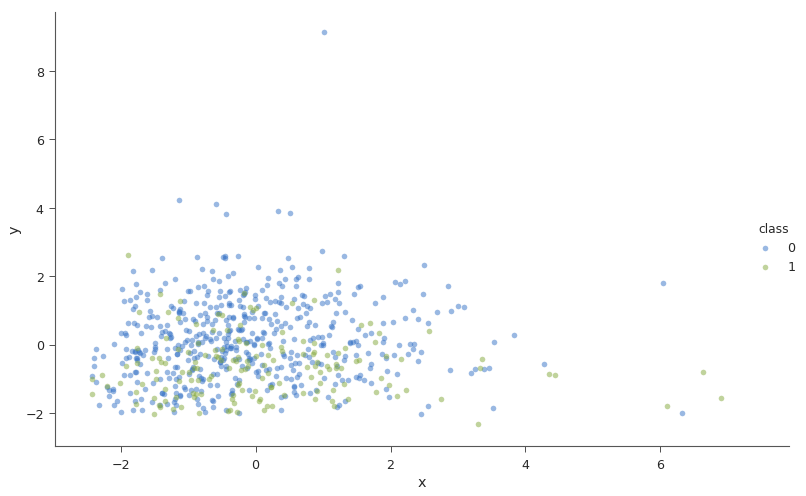

In [431]:
_ = sns.lmplot(x='x',
               y='y',
               hue='class',
               x_jitter=True,
               y_jitter=True,
               fit_reg=False,
               size=7,
               aspect = 1.5,
               data=pca_original_df,
               scatter_kws={'alpha':0.5})

<br>
<br>
**Visualizing resampled data in 2D**
<br>
<br>

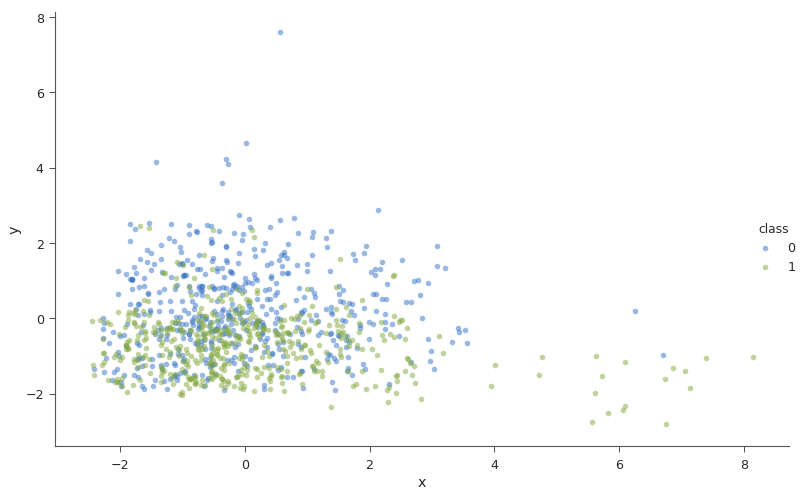

In [432]:
_ = sns.lmplot(x='x',
               y='y',
               hue='class',
               x_jitter=True,
               y_jitter=True,
               fit_reg=False,
               size=7,
               aspect = 1.5,
               data=pca_resampled_df,
               scatter_kws={'alpha':0.5})

<br>
<br>

I have tried building models on the resampled dataset, but the performance did not improve. Let's try doing some feature engineering on the dataset.
<br>
<br>

In [433]:
df.head()

,months_since_last_donation,num_donations,vol_donations,months_since_first_donation,class
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


<br>
<br>
**submission**
<br>
<br>

In [434]:
def create_submission(clf):
    test = pd.read_csv("test.csv")
    test.columns = ['id','months_since_last_donation','num_donations','vol_donations','months_since_first_donation']
    submit_id, submit_test = test['id'] , test.drop(['id','vol_donations'],axis=1)
    submit_test_scaled = scaler.transform(submit_test) #scale the data
    predictions = clf.predict_proba(submit_test_scaled)
    predictions = predictions[:,1] #only predictions for class-1 needs to be submitted
    pred_report = pd.DataFrame(predictions.tolist(),index=submit_id,columns=["Made Donation in March 2007"])    
    return pred_report

---

## Utility Functions

---

In [25]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Accent):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return


def prediction_report(true_label,predicted_label,classes=[0,1]):
    
    report = classification_report(true_label, predicted_label)
    print "classification report:\n",report
    cnf_matrix = confusion_matrix(true_label, predicted_label)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(15,10))
    plot_confusion_matrix(cnf_matrix, classes=classes,title='Confusion matrix, without normalization')
    return



---
## Models
---

In [381]:
from sklearn.svm import SVC;
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier;
from keras.wrappers.scikit_learn import KerasClassifier
np.random.seed(2017)

early_stopping_monitor = EarlyStopping(monitor='val_loss',patience=5)

def create_mlp():
    model = Sequential()
    model.add(Dropout(0.25,input_shape=(x_train_scaled.shape[1],)))
    model.add(Dense(100,activation='relu',input_shape=(x_train_scaled.shape[1],)))
    model.add(Dropout(0.25))
    model.add(Dense(100,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(2,activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model


svc = SVC(verbose=1,C=10,gamma=0.1,kernel='rbf',random_state=2017,probability=True);
svc.fit(x_train_scaled,y_train);

logit_model = LogisticRegression(random_state=2017)
logit_model.fit(x_train_scaled,y_train)

rf = RandomForestClassifier(n_estimators=100,max_depth=6,class_weight='balanced',n_jobs=4,random_state=2017)
rf.fit(x_train_scaled,y_train)

xgb = XGBClassifier(learning_rate=0.03,max_depth=5,n_estimators=250,reg_alpha=0.01)
xgb.fit(x_train_scaled,y_train)

mlp = KerasClassifier(build_fn=create_mlp, epochs=20, batch_size=10, validation_split=0.2,verbose=False)


models = {'SVC': svc,
          'Logistic Regression': logit_model,
          'Random Forest': rf,
          'XGBoost': xgb,
          'mlp': mlp
         }




[LibSVM]

<br>
<br>
Grid search for the best parameters of our models
<br>
<br>

In [327]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10,100,1000], 'gamma': [1e-1,1e-2,1e-3,1,10,100]}
svc_grid = SVC(probability=True,verbose=True)
clf = GridSearchCV(svc_grid, parameters,scoring='neg_log_loss',verbose=True,n_jobs=4)
clf.fit(x_train_scaled,y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:  6.0min


[LibSVM]

[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed: 10.1min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=True)

In [342]:
pd.DataFrame(clf.cv_results_)[['mean_test_score',
                               'mean_train_score',
                               'param_C',
                               'param_gamma',
                               'param_kernel',
                               'rank_test_score']].sort_values('rank_test_score')[:5]

,mean_test_score,mean_train_score,param_C,param_gamma,param_kernel,rank_test_score
13,-0.489120,-0.470714,10,0.1,rbf,1
7,-0.494660,-0.456200,1,1,rbf,2
39,-0.496060,-0.474736,1000,0.01,rbf,3
25,-0.497201,-0.459765,100,0.1,rbf,4
1,-0.505502,-0.490678,1,0.1,rbf,5


<br>
<br>
**Cross-validation**
<br>
<br>

In [386]:
np.random.seed(2017)
print "Cross-validation score"
print  "========================="
for model_name, model in models.items():
    if model_name=='mlp':
        cv_score = cross_val_score(estimator=model,X=x_train_scaled,y=to_categorical(y_train),
                                   scoring='neg_log_loss',
                                   cv=10,
                                   n_jobs=4,
                                   verbose=False,
                                   fit_params={'callbacks':[early_stopping_monitor]})
    else:
        cv_score = cross_val_score(estimator=model,
                                   X=x_train_scaled,
                                   y=y_train,
                                   cv=10,
                                   n_jobs=4,
                                   scoring='neg_log_loss',
                                   verbose=False)
    print model_name," ",-cv_score.mean(),"+/-",cv_score.std()

Cross-validation score
mlp   0.478453494027 +/- 0.0807720022143
XGBoost   0.535469900327 +/- 0.100141966183
SVC   0.491209526548 +/- 0.0481133206892
Logistic Regression   0.47551648798 +/- 0.0601495385611
Random Forest   0.556231217696 +/- 0.0740108456588


<br>
<br>
**Test the models on test set**
<br>
<br>

In [402]:
np.random.seed(2017)
print "Log loss"
print "=============="
for model_name,model in models.items():
    if model_name == 'mlp':
        mlp.fit(x_train_scaled,to_categorical(y_train)) ##need to fit the model before predicting
    y_pred = model.predict_proba(x_test_scaled)
    print model_name,": ",log_loss(y_test,y_pred)    

Log loss
mlp :  0.519841400829
XGBoost :  0.592722008402
SVC :  0.516236741052
Logistic Regression :  0.52176733679
Random Forest :  0.612271296484


<br>
<br>
## Feature Engineering
<br>
<br>

In [435]:
df.head()

,months_since_last_donation,num_donations,vol_donations,months_since_first_donation,class
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [436]:
df['num_donations_per_month'] = df['num_donations']*1.0/df['months_since_first_donation']

In [437]:
df['months_between_first_n_last_donation'] = df['months_since_first_donation'] - df['months_since_last_donation']

In [438]:
df.head()

,months_since_last_donation,num_donations,vol_donations,months_since_first_donation,class,num_donations_per_month,months_between_first_n_last_donation
0,2,50,12500,98,1,0.510204,96
1,0,13,3250,28,1,0.464286,28
2,1,16,4000,35,1,0.457143,34
3,2,20,5000,45,1,0.444444,43
4,1,24,6000,77,0,0.311688,76


In [448]:
np.corrcoef(df.months_since_first_donation,df.months_between_first_n_last_donation)

array([[ 1.  ,  0.94],
       [ 0.94,  1.  ]])

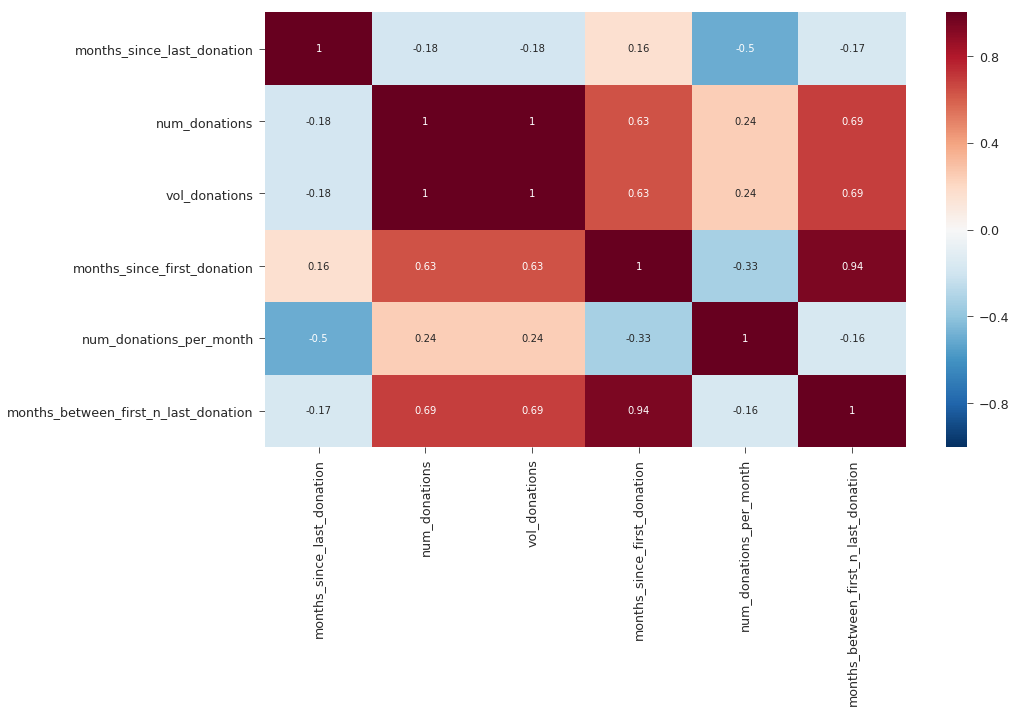

In [444]:

corr = df.drop('class',axis=1).corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True
           );